In [187]:
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [188]:
def pair_currency_value(currencies, size_train, name_predict_column):
    # Set the target currency
    target_currency = currencies[0]

    # Define date range for data fetching
    end_date = datetime.today().strftime('%Y-%m-%d')
    start_date = (datetime.today() - timedelta(days=15 * 365)).strftime('%Y-%m-%d')

    # Create an empty DataFrame to store currency data
    currency_data = pd.DataFrame()

    # Loop through each currency and download historical data
    for currency in currencies:
        data = yf.download(currency, start=start_date, end=end_date)
        currency_data[currency] = data['Close']
    
    # Drop rows with missing values
    currency_data.dropna(inplace=True)

    # Standardize the currency data (excluding the target currency)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(currency_data.drop(columns=[target_currency]))

    # Perform PCA with 2 components
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(scaled_data)

    # Create a DataFrame for the principal components
    pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])

    # Combine PCA components with the target currency
    target_values = currency_data[target_currency].reset_index(drop=True)
    combined_data = pd.concat([pca_df, target_values], axis=1)

    # Split the data into training and testing sets
    train_size = int(len(combined_data) * size_train)
    train_data = combined_data[:train_size]
    test_data = combined_data[train_size:]

    # Fit the ARIMA model on the training data
    model = ARIMA(train_data[target_currency], exog=train_data[['PC1', 'PC2']], order=(0, 0, 0))
    model_fit = model.fit()

    # Forecast future values using the test data
    forecast = model_fit.forecast(steps=len(test_data), exog=test_data[['PC1', 'PC2']])

    # Add the forecast results to the test DataFrame
    test_data['Forecast'] = forecast

    # Select the actual and forecasted values and assign dates
    result_df = test_data[[target_currency, 'Forecast']]
    result_df.index = currency_data.index[train_size:]

    # Rename the forecast column as per the provided name
    result_df = result_df.rename(columns={'Forecast': name_predict_column})

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(result_df[target_currency], result_df[name_predict_column]))

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((result_df[target_currency] - result_df[name_predict_column]) / result_df[target_currency])) * 100

    # Create a DataFrame to show the metrics
    metrics_df = pd.DataFrame({
        'Metric': ['RMSE', 'MAPE'],
        'Value': [rmse, mape]
    })

    # # Print the ARIMA model equation and metrics
    # print(f"ARIMA Model Equation: {model_fit.params}")
    # print("\nModel Metrics:")
    # print(metrics_df)

    # # Plot ACF and PACF
    # plt.figure(figsize=(12, 6))
    
    # plt.subplot(1, 2, 1)
    # plot_acf(model_fit.resid, lags=20, ax=plt.gca())
    # plt.title('ACF of Residuals')

    # plt.subplot(1, 2, 2)
    # plot_pacf(model_fit.resid, lags=20, ax=plt.gca())
    # plt.title('PACF of Residuals')

    # plt.tight_layout()
    # plt.show()

    return result_df, metrics_df

In [189]:
# Define the list of currencies
currencies_commodities = ['BRL=X', 'ZAR=X', 'ARS=X', 'CLP=X', 'COP=X', 'PEN=X', 'AUD=X', 'NZD=X']
currencies_emergentes = ['BRL=X', 'ZAR=X', 'ARS=X', 'CLP=X', 'COP=X', 'PEN=X', 'TRY=X', 'MXN=X', 'PLN=X', 'HUF=X']

# Run the model for emerging currencies and commodities currencies
df_commodities, commodities_metrics = pair_currency_value(currencies_commodities, 0.97, 'Commodities')
df_emergentes, emergents_metrics = pair_currency_value(currencies_emergentes, 0.97, 'Emergents')

# Merge the two DataFrames on 'Date' and the target currency 'BRL=X'
merged_df = pd.merge(df_emergentes, df_commodities, on = ["Date","BRL=X"])



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_16813/3868851555.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Forecast'] = forecast
[*********************100%%***************

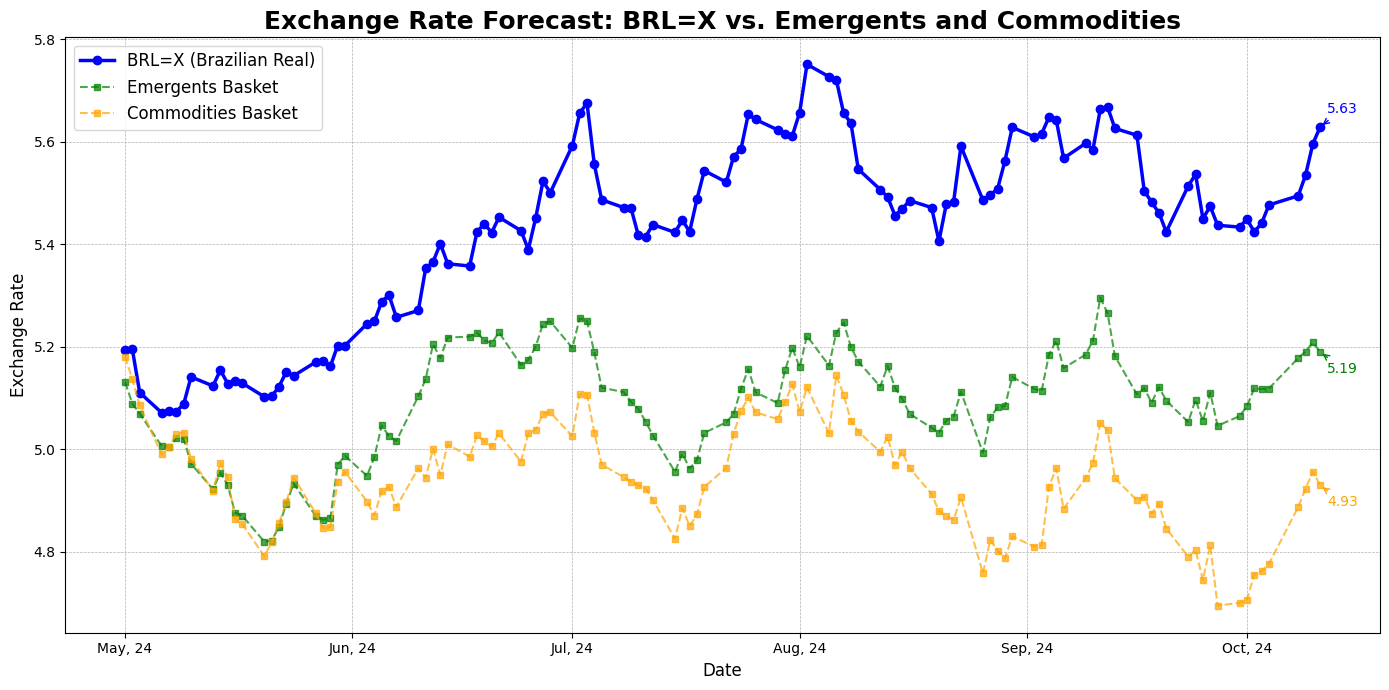

In [190]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plotting the Exchange Rate Forecasts for BRL=X
plt.figure(figsize=(14, 7))

# Plot BRL=X with a thicker line, custom color, and circular markers
plt.plot(merged_df.index, merged_df['BRL=X'], label='BRL=X (Brazilian Real)', color='blue', 
         marker='o', markersize=6, linewidth=2.5)

# Plot Emergents with a thinner line, custom linestyle, transparency, and square markers
plt.plot(merged_df.index, merged_df['Emergents'], label='Emergents Basket', color='green', linestyle='--', 
         alpha=0.7, marker='s', markersize=5, linewidth=1.5)

# Plot Commodities with a thinner line, custom linestyle, transparency, and square markers
plt.plot(merged_df.index, merged_df['Commodities'], label='Commodities Basket', color='orange', linestyle='--', 
         alpha=0.7, marker='s', markersize=5, linewidth=1.5)

# Annotate the last value for BRL=X
plt.annotate(f"{merged_df['BRL=X'].iloc[-1]:.2f}", 
             xy=(merged_df.index[-1], merged_df['BRL=X'].iloc[-1]), 
             xytext=(5, 10), 
             textcoords="offset points", 
             fontsize=10, 
             color='blue', 
             arrowprops=dict(arrowstyle='->', color='blue'))

# Annotate the last value for Emergents
plt.annotate(f"{merged_df['Emergents'].iloc[-1]:.2f}", 
             xy=(merged_df.index[-1], merged_df['Emergents'].iloc[-1]), 
             xytext=(5, -15), 
             textcoords="offset points", 
             fontsize=10, 
             color='green', 
             arrowprops=dict(arrowstyle='->', color='green'))

# Annotate the last value for Commodities
plt.annotate(f"{merged_df['Commodities'].iloc[-1]:.2f}", 
             xy=(merged_df.index[-1], merged_df['Commodities'].iloc[-1]), 
             xytext=(5, -15), 
             textcoords="offset points", 
             fontsize=10, 
             color='orange', 
             arrowprops=dict(arrowstyle='->', color='orange'))

# Customize the axes labels
plt.xlabel('Date', fontsize=12)
plt.ylabel('Exchange Rate', fontsize=12)

# Set the title of the chart with a larger font
plt.title('Exchange Rate Forecast: BRL=X vs. Emergents and Commodities', fontsize=18, fontweight='bold')

# Format x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b, %y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to be every month

# Add grid lines for better readability, using dashed lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Improve the legend layout, positioning it optimally
plt.legend(loc='best', fontsize=12)

# Set the x-axis date labels to horizontal
plt.xticks(rotation=0)

# Optimize the layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()


In [191]:
print(commodities_metrics)
print(emergents_metrics)

  Metric     Value
0   RMSE  0.528192
1   MAPE  8.983354
  Metric     Value
0   RMSE  0.363790
1   MAPE  6.249351
